## ResNet152 + CLIP + MLP Classifier

### Dataset for Fine-Tuning

Since, I have already extracted the features using `ResNet152` and `CLIP` model. I simply load the extracted features from both models and concatenate them, along with the labels to create the dataset for fine-tuning. This reduces the time of preprocessing or loading the images again and speeds up the process considerably.

In [ ]:
image_features = [torch.load(fname) for fname in [f'Fatima-Fellowship-Challenge/output/{i}.pt' for i in range(37)]]
image_labels = [torch.load(fname) for fname in [f'Fatima-Fellowship-Challenge/label/{i}.pt' for i in range(37)]]

In [ ]:
image_features1 = [torch.load(fname) for fname in [f'Fatima-Fellowship-Challenge/output-clip/{i}.pt' for i in range(37)]]

In [ ]:
image_features = torch.concatenate(image_features)
image_features1 = torch.concatenate(image_features1)

In [ ]:
image_features = torch.concatenate([image_features, image_features1], -1)
image_labels = torch.concatenate(image_labels)

In [ ]:
image_features.shape, image_labels.shape

(torch.Size([18618, 2816]), torch.Size([18618]))

#### Train & Test Split

Since, I don't have labels for test data. I create train & validation split:
- Validation: 1000 images ($\sim 5\%$) of the total training dataset.
- Train: Remaining images of the total training dataset after selecting validation set.

This was done mainly to evaluate the performance of our model on validation dataset.

In [ ]:
# Creating train and validation datasets and their respective dataloaders
BATCH_SIZE = 256
VAL_SIZE = 1000
traindataset = TensorDataset(image_features[:-VAL_SIZE], image_labels[:-VAL_SIZE])
trainloader = DataLoader(traindataset, BATCH_SIZE, True)
valdataset = TensorDataset(image_features[-VAL_SIZE:], image_labels[-VAL_SIZE:])
valloader = DataLoader(valdataset, 1000)

#### Classifier

In [ ]:
classifier = nn.Sequential(
    nn.Linear(2816, 2)
)

clasifier = classifier.cuda()

#### Loss and Optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(classifier.parameters(), lr=1e-4, weight_decay=1e-5)

#### Training Classifier

In [ ]:
# Training Classifier till 150 Epochs
NUM_EPOCHS = 150
train_loss = list()
val_loss = list()

for epoch in range(NUM_EPOCHS):

  running_loss = 0.0
  for i, data in enumerate(trainloader):

    inputs, labels = data

    inputs = inputs.cuda()
    labels = labels.cuda()

    optimizer.zero_grad()

    outputs = classifier(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 50 == 49:
      with torch.no_grad():
        inps, labs = next(iter(valloader))
        inps = inps.cuda()
        labs = labs.cuda()
        out = classifier(inps)
        val_los = criterion(out, labs).item()

      train_loss.append(running_loss)
      val_loss.append(val_los)

      print(f'[{epoch + 1}, {i + 1:5d}] train_loss: {running_loss:.3f} | val_loss: {val_los:.3f}')
      running_loss = 0.0
            

print('Finished Training')

[1,    50] train_loss: 23.943 | val_loss: 0.350
[2,    50] train_loss: 14.275 | val_loss: 0.264
[3,    50] train_loss: 12.244 | val_loss: 0.231
[4,    50] train_loss: 11.029 | val_loss: 0.208
[5,    50] train_loss: 10.146 | val_loss: 0.193
[6,    50] train_loss: 9.471 | val_loss: 0.185
[7,    50] train_loss: 9.103 | val_loss: 0.174
[8,    50] train_loss: 8.618 | val_loss: 0.167
[9,    50] train_loss: 8.321 | val_loss: 0.161
[10,    50] train_loss: 7.874 | val_loss: 0.157
[11,    50] train_loss: 7.736 | val_loss: 0.153
[12,    50] train_loss: 7.556 | val_loss: 0.148
[13,    50] train_loss: 7.298 | val_loss: 0.146
[14,    50] train_loss: 7.114 | val_loss: 0.142
[15,    50] train_loss: 6.991 | val_loss: 0.141
[16,    50] train_loss: 6.807 | val_loss: 0.138
[17,    50] train_loss: 6.851 | val_loss: 0.135
[18,    50] train_loss: 6.455 | val_loss: 0.133
[19,    50] train_loss: 6.349 | val_loss: 0.135
[20,    50] train_loss: 6.567 | val_loss: 0.131
[21,    50] train_loss: 6.351 | val_loss: 0.

In [ ]:
# save model
if not os.path.exists('Fatima-Fellowship-Challenge/model'):
  os.mkdir('Fatima-Fellowship-Challenge/model')
torch.save(classifier.state_dict(), 'Fatima-Fellowship-Challenge/model/resnet152_clip_mlp')

#### Training Dynamics

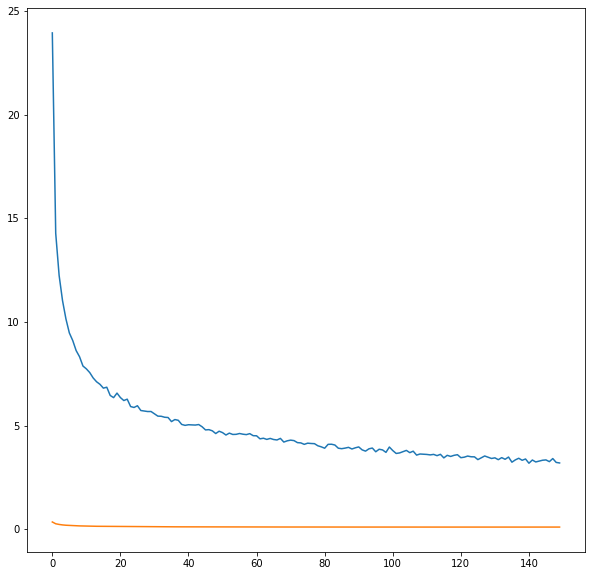

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(train_loss)
plt.plot(val_loss)

### Inference & Evaluation

In [ ]:
# Evaluation of model performance on validation set
with torch.no_grad():
  pred_probs = classifier(next(iter(valloader))[0])

# The model's prediction
preds = np.argmax(pred_probs.cpu(), 1)

# Accuracy 
print('Accuracy:', torch.sum(preds == next(iter(valloader))[1].cpu()) / len(valdataset))

Accuracy: tensor(0.9550)


### Misclassified Images

Confusion Matrix for the model's performance is shown below.

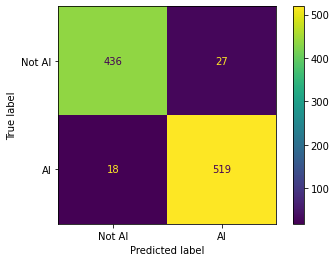

In [ ]:
# confusion matrix
cm = confusion_matrix(next(iter(valloader))[1].cpu(), preds)
cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Not AI', 'AI'])
cm_display.plot()
plt.show() 

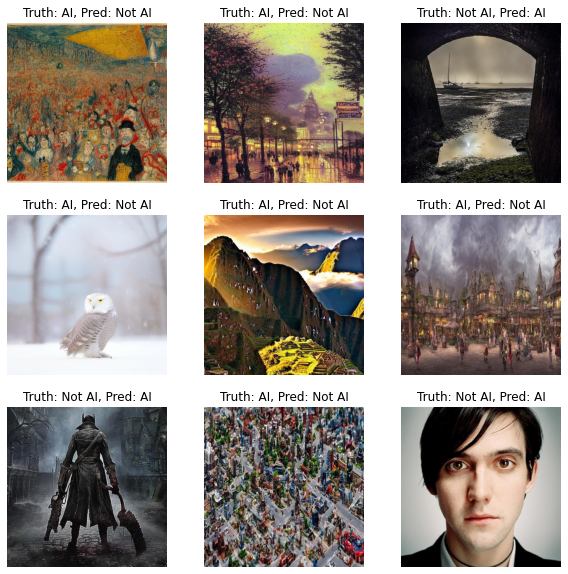

In [ ]:
# Misclassified Images
misclassified = list(((preds != next(iter(valloader))[1].cpu())).nonzero().squeeze().numpy())

# Validation Dataset
val_data = dataset[-VAL_SIZE:]

# Visualize Dataset
labels_map = {
    0: "Not AI",
    1: "AI"
}

figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = misclassified[random.randint(0, len(misclassified)-1)]
    img, label = val_data['image'][sample_idx], val_data['label'][sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f'Truth: {labels_map[label]}, Pred: {labels_map[list(preds.numpy())[sample_idx]]}')
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()